## Using Regression Analysis to Test the "Hot Hand"

In this section, we will use regression analysis to test for the "hot hand." 

#### Import useful libraries and the shot log data

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

Shotlog=pd.read_csv("../../Data/Week 6/Shotlog2.csv")
Player_Stats=pd.read_csv("../../Data/Week 6/Player_Stats2.csv")
Player_Shots=pd.read_csv("../../Data/Week 6/Player_Shots2.csv")
Shotlog.head()

,team_previous_shot,player_position,home_game,location_x,opponent_previous_shot,home_team,shot_type,points,away_team,location_y,...,shoot_player,time_from_last_shot,quarter,current_shot_outcome,current_shot_hit,lag_shot_hit,average_hit,shot_count,shot_per_game,conse_shot_hit
0,MISSED,SF,Yes,279.0,SCORED,ATL,Jump Shot,3,WAS,130.0,...,Kent Bazemore,4.0,1,MISSED,0,0.0,0.408587,722,7,0
1,MISSED,SF,Yes,58.0,SCORED,ATL,Cutting Layup Shot,2,WAS,275.0,...,Kent Bazemore,30.0,2,MISSED,0,0.0,0.408587,722,7,0
2,SCORED,SF,Yes,868.0,SCORED,ATL,Jump Shot,3,WAS,475.0,...,Kent Bazemore,47.0,3,MISSED,0,0.0,0.408587,722,7,0
3,SCORED,SF,Yes,691.0,MISSED,ATL,Pullup Jump Shot,3,WAS,100.0,...,Kent Bazemore,39.0,3,SCORED,1,0.0,0.408587,722,7,0
4,MISSED,SF,Yes,691.0,MISSED,ATL,Pullup Jump Shot,2,WAS,181.0,...,Kent Bazemore,20.0,3,MISSED,0,1.0,0.408587,722,7,0


### Prediction Error
Let's create a variable that equals to the difference between the outcome of the shot and the average success rate. Since we typically use the average success rate to predict the outcome of the shot, this difference will capture the prediction error. 

In [2]:
Shotlog['error']=Shotlog['current_shot_hit']-Shotlog['average_hit']
Shotlog['lagerror']=Shotlog['lag_shot_hit']-Shotlog['average_hit']
Shotlog.head()

,team_previous_shot,player_position,home_game,location_x,opponent_previous_shot,home_team,shot_type,points,away_team,location_y,...,quarter,current_shot_outcome,current_shot_hit,lag_shot_hit,average_hit,shot_count,shot_per_game,conse_shot_hit,error,lagerror
0,MISSED,SF,Yes,279.0,SCORED,ATL,Jump Shot,3,WAS,130.0,...,1,MISSED,0,0.0,0.408587,722,7,0,-0.408587,-0.408587
1,MISSED,SF,Yes,58.0,SCORED,ATL,Cutting Layup Shot,2,WAS,275.0,...,2,MISSED,0,0.0,0.408587,722,7,0,-0.408587,-0.408587
2,SCORED,SF,Yes,868.0,SCORED,ATL,Jump Shot,3,WAS,475.0,...,3,MISSED,0,0.0,0.408587,722,7,0,-0.408587,-0.408587
3,SCORED,SF,Yes,691.0,MISSED,ATL,Pullup Jump Shot,3,WAS,100.0,...,3,SCORED,1,0.0,0.408587,722,7,0,0.591413,-0.408587
4,MISSED,SF,Yes,691.0,MISSED,ATL,Pullup Jump Shot,2,WAS,181.0,...,3,MISSED,0,1.0,0.408587,722,7,0,-0.408587,0.591413


We can graph the outcome of the shots to see if there is any pattern over time in the variable.

We will look at LeBron James' performance during the regular season as an example.

In [3]:
Shotlog['time'] = pd.to_timedelta(Shotlog['time'])
Shotlog['time'].describe()

count                    185052
mean     0 days 00:06:20.229465
std      0 days 00:03:23.013120
min             0 days 00:00:00
25%             0 days 00:03:30
50%             0 days 00:06:19
75%             0 days 00:09:14
max             0 days 00:12:00
Name: time, dtype: object

We will first graph the outcome of LeBron James' shots in a single game on April 9th, 2017.

(To make this graph, we use a small trick. Instead of asking Python to produce a scatter plot with the "plot.scatter" command, we ask Python to graph a line plot, but specify the width of the line to be 0. So essentially we produce a scatter plot. The reason we do it this way is because in Python, scatter plot requires the x axis to be numeric. It does not allow scatter plot where the x axis is a date or time variable.)

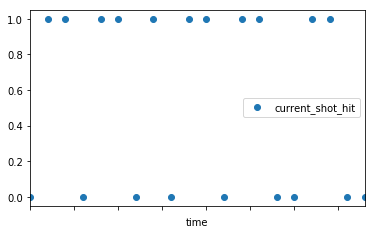

In [4]:
Shotlog[(Shotlog.shoot_player == 'LeBron James')&(Shotlog.date=='2017-04-09')].plot(x='time', y='current_shot_hit', marker='o', linewidth=0)

Let's create a graph of the outcomes of individual shots for Lebron James throughout the regular season. We will create a subgraph for each game he played.


We will first subset a dataset that includes only LeBron James' data.

In [5]:
LeBron_James=Shotlog[(Shotlog.shoot_player == 'LeBron James')]
LeBron_James.head()

,team_previous_shot,player_position,home_game,location_x,opponent_previous_shot,home_team,shot_type,points,away_team,location_y,...,quarter,current_shot_outcome,current_shot_hit,lag_shot_hit,average_hit,shot_count,shot_per_game,conse_shot_hit,error,lagerror
34019,MISSED,SF,Yes,236.0,MISSED,CLE,Jump Shot,3,NYK,84.0,...,1,MISSED,0,1.0,0.547619,1344,14,0,-0.547619,0.452381
34020,BLOCKED,SF,Yes,264.0,SCORED,CLE,Jump Shot,3,NYK,383.0,...,1,MISSED,0,0.0,0.547619,1344,14,0,-0.547619,-0.547619
34021,SCORED,SF,Yes,50.0,MISSED,CLE,Running Layup,2,NYK,259.0,...,1,SCORED,1,0.0,0.547619,1344,14,0,0.452381,-0.547619
34022,MISSED,SF,Yes,52.0,SCORED,CLE,Putback Dunk,2,NYK,250.0,...,1,SCORED,1,1.0,0.547619,1344,14,1,0.452381,0.452381
34023,MISSED,SF,Yes,52.0,MISSED,CLE,Dunk,2,NYK,250.0,...,2,SCORED,1,1.0,0.547619,1344,14,1,0.452381,0.452381


Now we can graph prediction error for LeBron James for all the games separately in the season.

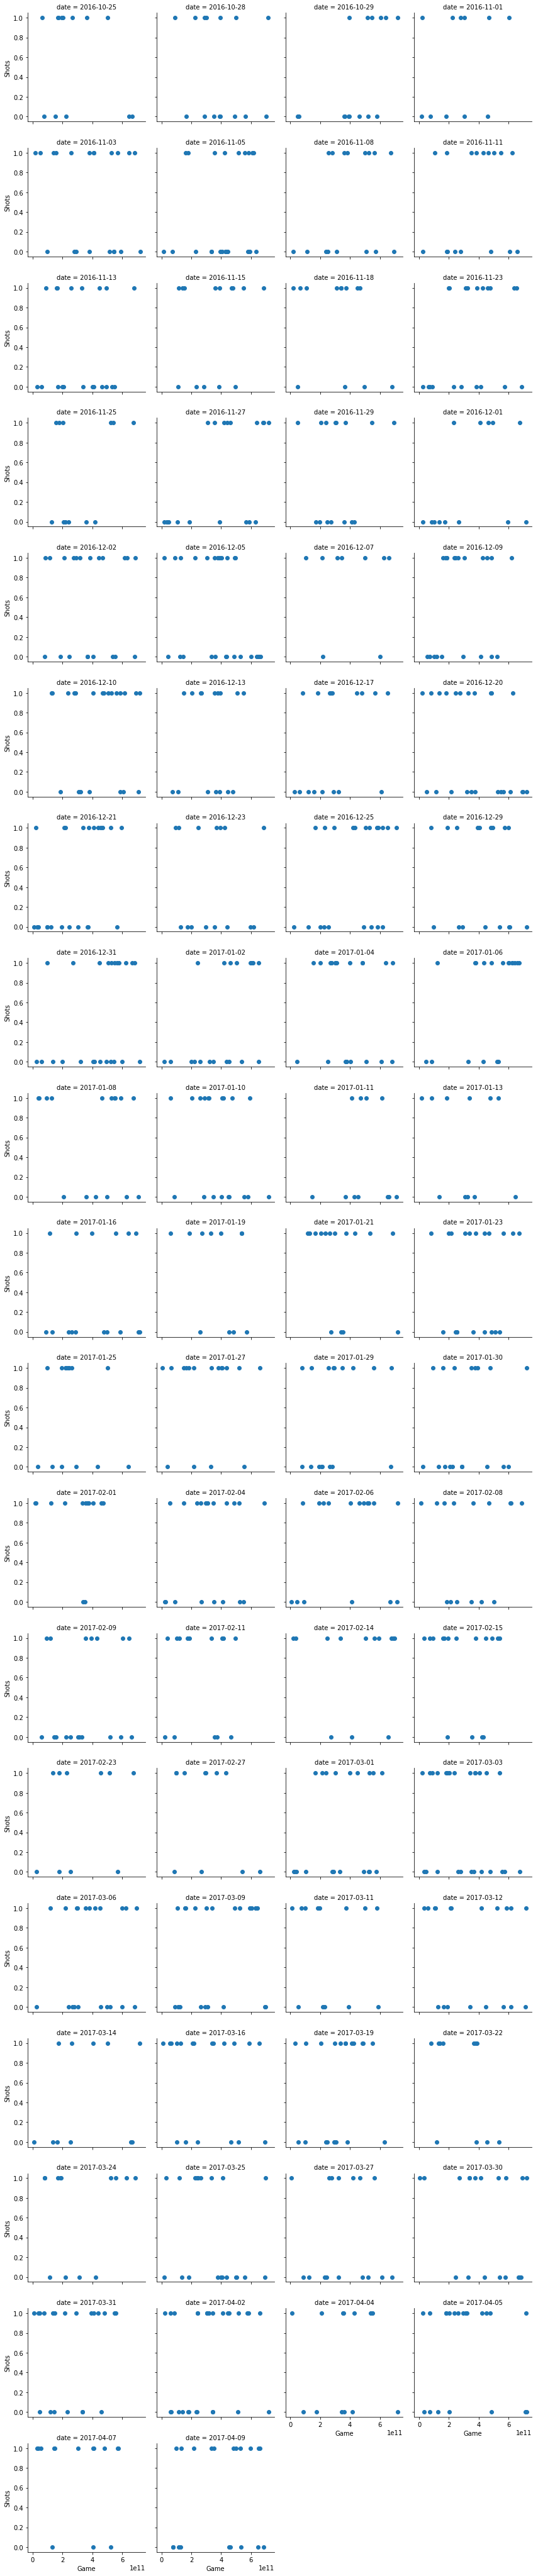

In [6]:
g = sns.FacetGrid(LeBron_James, col="date", col_wrap=4)
g = g.map(plt.plot, "time", "current_shot_hit", marker='o', linewidth=0)
g.set_axis_labels("Game", "Shots");

We will do a similar exercise for the statistics of Cheick Diallo.


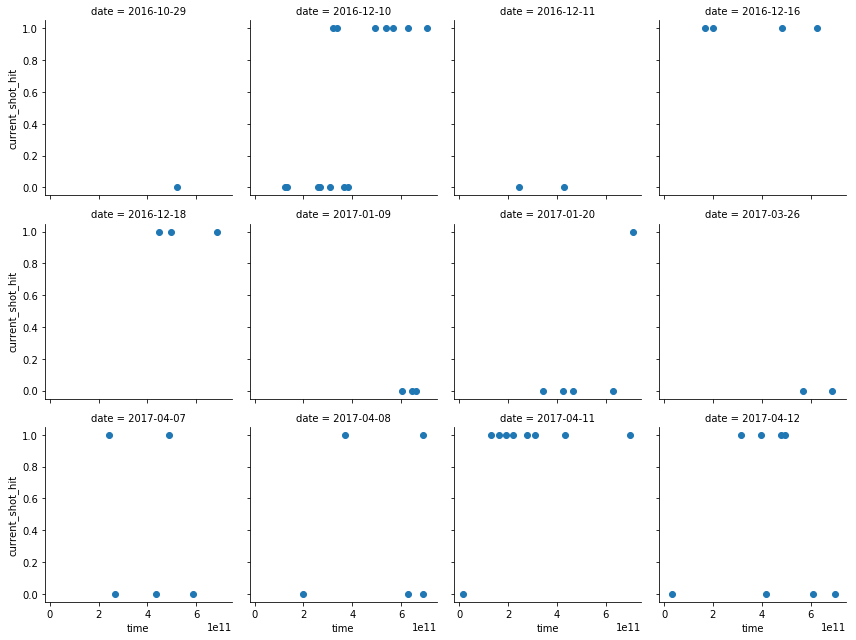

In [7]:
Cheick_Diallo=Shotlog[(Shotlog.shoot_player == 'Cheick Diallo')]
g = sns.FacetGrid(Cheick_Diallo, col="date", col_wrap=4)
g = g.map(plt.plot, "time", "current_shot_hit", marker='o', linewidth=0)

## Self Test - 1
### Graph the prediction error for James Jones
- Separate the shots by game
- Interpret your result

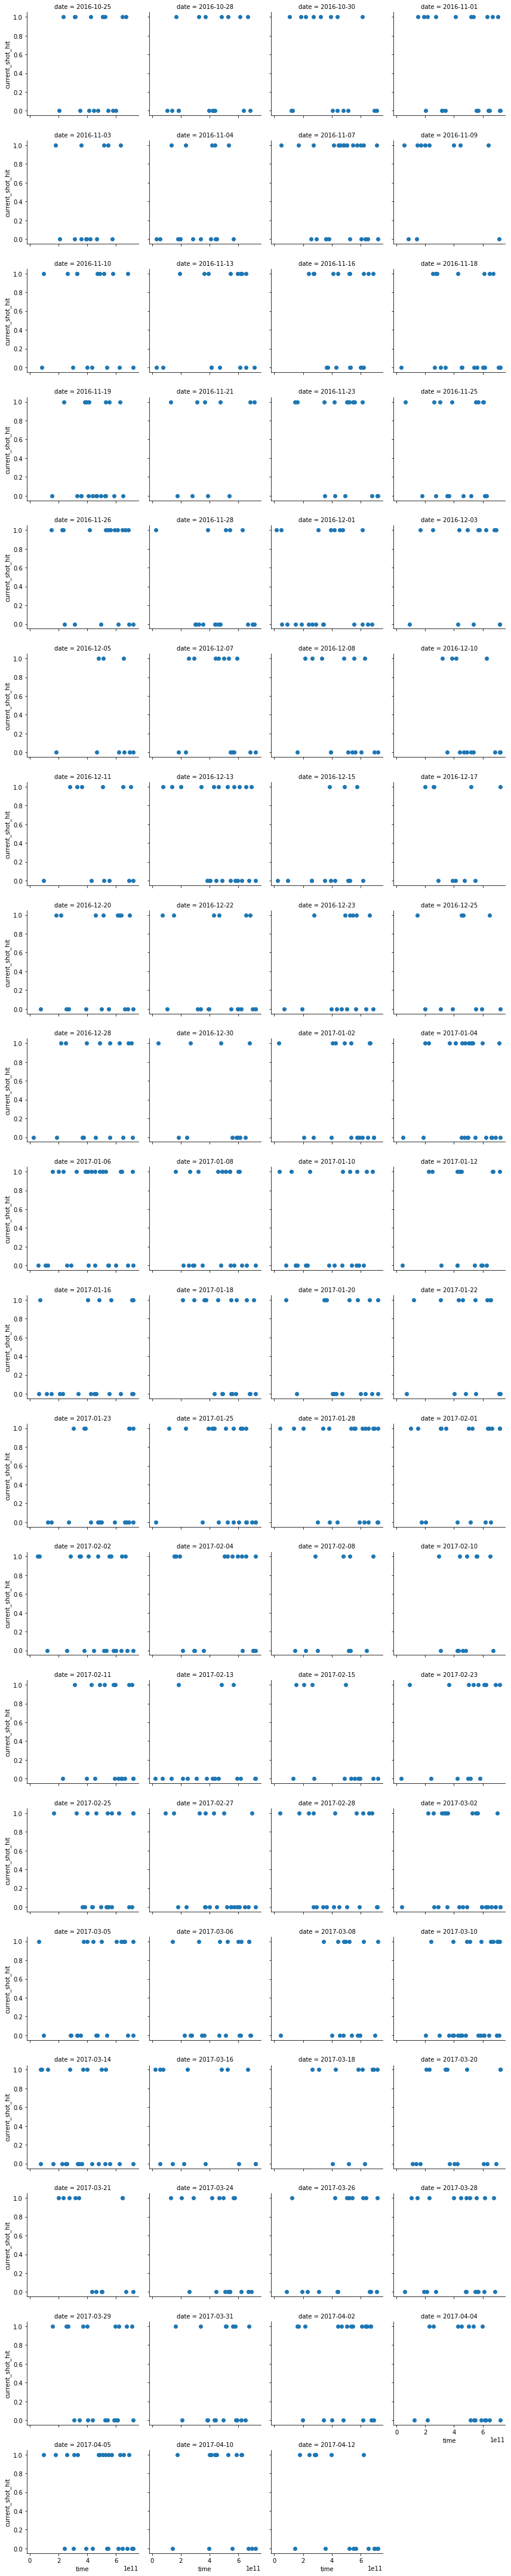

In [8]:
#Your Code Here
Stephen_curry= Shotlog[(Shotlog.shoot_player == 'Stephen Curry')]
g= sns.FacetGrid(Stephen_curry, col='date', col_wrap=4)
g= g.map(plt.plot, 'time', 'current_shot_hit', marker='o', linewidth=0)

### Regression analysis on prediction error
We will first run a simple regression of the prediction error of current period on the prediction error of previous period.

In [9]:
reg1 = sm.ols(formula = 'error ~ lagerror', data= Shotlog).fit()
print(reg1.summary())

                            OLS Regression Results                            
Dep. Variable:                  error   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     71.65
Date:                Thu, 22 Dec 2022   Prob (F-statistic):           2.58e-17
Time:                        16:25:34   Log-Likelihood:            -1.3244e+05
No. Observations:              185052   AIC:                         2.649e+05
Df Residuals:                  185050   BIC:                         2.649e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0018      0.001      1.589      0.1

_The estimated coefficient of the lagged error is statistically significant. However, the R-Squared for this regression is also zero. This means that our specified linear model is not a good fit for our data at all!_

There are a lot of factors that may influence the success of shot, for example, the player’s own skill as a shooter, the type of the shot, the atmosphere of the stadium (whether it is home or away game), and whether it is at the beginning or towards the end of the game. Let’s add these control variables in our regression.

In [10]:
reg2 = sm.ols(formula = 'error ~ lagerror+player_position+home_game+opponent_previous_shot+C(points)+time_from_last_shot+C(quarter)', data= Shotlog).fit()
print(reg2.summary())

                            OLS Regression Results                            
Dep. Variable:                  error   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     139.9
Date:                Thu, 22 Dec 2022   Prob (F-statistic):               0.00
Time:                        16:25:42   Log-Likelihood:            -1.2632e+05
No. Observations:              178281   AIC:                         2.527e+05
Df Residuals:                  178261   BIC:                         2.529e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

_We can see that the R-squared is now increased to 0.015 which is still very small. The estimate on lagerror is statistically significant, but the magnitude of the estimate is -0.0136 which is still very small. And it is negative, meaning that the success of the previous shot would hurt the chance of the subsequent shot. This is contrary to what the hot hand predicts._  

### Weighted least squares regression
As we have seen, some players had a lot of shot per game while some just had a few. Different players may have different variations in their success rate in the shots. We can run a weighted least squared regression to address this problem. 

Weighted least squares estimation weights the observations proportional to the reciprocal of the error variance of the observation. Thus weighted least squares can overcome the issue of non-constant variance.

#### We can use the “sm.wls” command to run the weighted least square regression weighted by the number of shot per game (weight=1/shot_per_game).

In [11]:
reg3 = sm.wls(formula = 'error ~ lagerror+player_position+home_game+opponent_previous_shot+points+time_from_last_shot+quarter',  weights=1/Shotlog['shot_per_game'] , data= Shotlog).fit()
print(reg3.summary())

                            WLS Regression Results                            
Dep. Variable:                  error   R-squared:                       0.015
Model:                            WLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     209.7
Date:                Thu, 22 Dec 2022   Prob (F-statistic):               0.00
Time:                        16:25:48   Log-Likelihood:            -1.3913e+05
No. Observations:              178281   AIC:                         2.783e+05
Df Residuals:                  178267   BIC:                         2.784e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

From our summary statistics, some players exhibit a stream of the success while some don’t. In our previous regressions, we are grouping all the players together. Let’s see if we can find any effect if we look at individual players.

#### Regression analysis on individual players

Run a regression of current error on lagged error for LeBron James.

In [12]:
reg_LeBron = sm.ols(formula = 'error ~ lagerror+home_game+opponent_previous_shot+C(points)+time_from_last_shot+C(quarter)', data= LeBron_James).fit()
print(reg_LeBron.summary())

                            OLS Regression Results                            
Dep. Variable:                  error   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     6.937
Date:                Thu, 22 Dec 2022   Prob (F-statistic):           1.89e-11
Time:                        16:25:48   Log-Likelihood:                -827.33
No. Observations:                1204   AIC:                             1679.
Df Residuals:                    1192   BIC:                             1740.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

Similarly, we can run a weighted least squares estimation on LeBron James’ prediction error, weighted by the number of shot he made in each game.

In [13]:
reg_LeBron_wls = sm.wls(formula = 'error ~ lagerror+home_game+opponent_previous_shot+points+time_from_last_shot+quarter',  weights=1/LeBron_James['shot_per_game'] , data= LeBron_James).fit()
print(reg_LeBron_wls.summary())

                            WLS Regression Results                            
Dep. Variable:                  error   R-squared:                       0.066
Model:                            WLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     12.15
Date:                Thu, 22 Dec 2022   Prob (F-statistic):           4.63e-15
Time:                        16:25:49   Log-Likelihood:                -837.48
No. Observations:                1204   AIC:                             1691.
Df Residuals:                    1196   BIC:                             1732.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

We can also take a look back at LeBron James’ autocorrelation coefficient. 

In [14]:
Shotlog[(Shotlog.shoot_player == 'LeBron James')][['current_shot_hit','lag_shot_hit']].corr()

,current_shot_hit,lag_shot_hit
current_shot_hit,1.000000,-0.033244
lag_shot_hit,-0.033244,1.000000


In [15]:
JR_smith= Shotlog[(Shotlog.shoot_player == 'J.R. Smith')]
JR_smith

,team_previous_shot,player_position,home_game,location_x,opponent_previous_shot,home_team,shot_type,points,away_team,location_y,...,quarter,current_shot_outcome,current_shot_hit,lag_shot_hit,average_hit,shot_count,shot_per_game,conse_shot_hit,error,lagerror
36637,MISSED,SG,Yes,229.0,MISSED,CLE,Jump Shot,3,NYK,427.0,...,1,SCORED,1,1.0,0.345506,356,13,1,0.654494,0.654494
36638,SCORED,SG,Yes,279.0,MISSED,CLE,Jump Shot,3,NYK,339.0,...,1,MISSED,0,1.0,0.345506,356,13,0,-0.345506,0.654494
36639,MISSED,SG,Yes,249.0,SCORED,CLE,Jump Shot,3,NYK,87.0,...,1,MISSED,0,0.0,0.345506,356,13,0,-0.345506,-0.345506
36640,BLOCKED,SG,Yes,221.0,SCORED,CLE,Turnaround Jump Shot,2,NYK,318.0,...,1,MISSED,0,0.0,0.345506,356,13,0,-0.345506,-0.345506
36641,SCORED,SG,Yes,171.0,SCORED,CLE,Jump Shot,3,NYK,31.0,...,2,SCORED,1,0.0,0.345506,356,13,0,0.654494,-0.345506
36642,SCORED,SG,Yes,210.0,SCORED,CLE,Jump Shot,2,NYK,318.0,...,2,MISSED,0,1.0,0.345506,356,13,0,-0.345506,0.654494
36643,SCORED,SG,Yes,82.0,MISSED,CLE,Jump Shot,3,NYK,483.0,...,2,MISSED,0,0.0,0.345506,356,13,0,-0.345506,-0.345506
36644,SCORED,SG,Yes,40.0,MISSED,CLE,Jump Shot,3,NYK,478.0,...,2,MISSED,0,0.0,0.345506,356,13,0,-0.345506,-0.345506
36645,SCORED,SG,Yes,758.0,MISSED,CLE,Jump Shot,3,NYK,27.0,...,3,MISSED,0,0.0,0.345506,356,13,0,-0.345506,-0.345506
36646,SCORED,SG,Yes,861.0,MISSED,CLE,Jump Shot,2,NYK,176.0,...,3,BLOCKED,0,0.0,0.345506,356,13,0,-0.345506,-0.345506


_The autocorrelation coefficient between the outcomes of the current shot and the previous shot for LeBron James is very small._

We can do a similar exercise for James Jones. We will start with an ordinary least square regression. 

In [16]:
reg_Smith = sm.ols(formula = 'error ~ lagerror+home_game+opponent_previous_shot+C(points)+time_from_last_shot+C(quarter)', data= JR_smith).fit()
print(reg_Smith.summary())

                            OLS Regression Results                            
Dep. Variable:                  error   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                 -0.009
Method:                 Least Squares   F-statistic:                    0.7455
Date:                Thu, 22 Dec 2022   Prob (F-statistic):              0.694
Time:                        16:25:49   Log-Likelihood:                -198.32
No. Observations:                 306   AIC:                             420.6
Df Residuals:                     294   BIC:                             465.3
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

We will also run a weighted least squares estimation on Jones' statistics. Weight=1/shot_per_game.

In [17]:
reg_Smith_wls = sm.wls(formula = 'error ~ lagerror+home_game+opponent_previous_shot+points+time_from_last_shot+quarter',  weights=1/JR_smith['shot_per_game'] , data= JR_smith).fit()
print(reg_Smith_wls.summary())

                            WLS Regression Results                            
Dep. Variable:                  error   R-squared:                       0.021
Model:                            WLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.8975
Date:                Thu, 22 Dec 2022   Prob (F-statistic):              0.509
Time:                        16:25:49   Log-Likelihood:                -212.86
No. Observations:                 306   AIC:                             441.7
Df Residuals:                     298   BIC:                             471.5
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

## Self Test - 2

Use regression analysis to test "hot hand" for Cheick Diallo
1. Run an ordinary least square regression of current error on lagged error for Cheick Diallo.
2. Run a weighted least sqaure regression of current error on lagged error for Cheick Diallo, weight=1/shot_per_game.
3. Interpret your regression results.

In [18]:
#Your Code Here
reg_CD= sm.ols(formula= 'error ~ lagerror + home_game + opponent_previous_shot + points+ time_from_last_shot + quarter', data=Cheick_Diallo).fit()
print(reg_CD.summary())

                            OLS Regression Results                            
Dep. Variable:                  error   R-squared:                       0.113
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                    0.9492
Date:                Thu, 22 Dec 2022   Prob (F-statistic):              0.478
Time:                        16:25:49   Log-Likelihood:                -39.907
No. Observations:                  60   AIC:                             95.81
Df Residuals:                      52   BIC:                             112.6
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

In [20]:
#Your Code Here
reg_CD2= sm.ols(formula= 'error ~ lagerror + home_game + opponent_previous_shot + points+ time_from_last_shot + quarter', weights= 1/Cheick_Diallo.shot_per_game ,data=Cheick_Diallo).fit()
print(reg_CD2.summary())

                            OLS Regression Results                            
Dep. Variable:                  error   R-squared:                      -4.819
Model:                            OLS   Adj. R-squared:                 -5.602
Method:                 Least Squares   F-statistic:                    -6.152
Date:                Thu, 22 Dec 2022   Prob (F-statistic):               1.00
Time:                        16:39:01   Log-Likelihood:                -39.907
No. Observations:                  60   AIC:                             95.81
Df Residuals:                      52   BIC:                             112.6
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

#### More generally, we can define functions to run regressions for each individual player. 

- Define a function to run ordinary least square regression by player.

In [21]:
def reg_player(player):
    Shotlog_player=Shotlog[Shotlog.shoot_player==player]
    reg_player=sm.ols(formula = 'error ~ lagerror+home_game+opponent_previous_shot+points+time_from_last_shot+quarter', data= Shotlog_player).fit()
    print(reg_player.summary())
    return; 

We can then use this function for individual player, for example, Russell Westbrook.

In [ ]:
reg_player('Russell Westbrook')

- Define a function to run weighted least square regression by player.

In [23]:
def reg_wls_player(player):
    Shotlog_player=Shotlog[Shotlog.shoot_player==player]
    reg_wls_player=sm.wls(formula = 'error ~ lagerror+home_game+opponent_previous_shot+points+time_from_last_shot+quarter',weights=1/Shotlog_player['shot_per_game'] , data= Shotlog_player).fit()
    print(reg_wls_player.summary())
    return; 

Let's use this function to run a weighted least squares estimation for Russell Westbrook.

In [24]:
reg_wls_player('Russell Westbrook')

                            WLS Regression Results                            
Dep. Variable:                  error   R-squared:                       0.014
Model:                            WLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     3.656
Date:                Thu, 22 Dec 2022   Prob (F-statistic):           0.000632
Time:                        16:39:22   Log-Likelihood:                -1325.2
No. Observations:                1828   AIC:                             2666.
Df Residuals:                    1820   BIC:                             2711.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

#### We can extract estimated coefficient on the lagged error for each player. 
- Create a list of unique player names

In [25]:
player_list = np.array(Shotlog['shoot_player'])
player_list = np.unique(player_list)

In [32]:
player_list[0]

'A.J. Hammons'

- Run weighted least squares regression for each player by specifying "shoot_play==player_list[index]"

In [31]:
Shotlog_player=Shotlog[Shotlog.shoot_player==player_list[0]]
reg_player=sm.wls(formula = 'error ~ lagerror+home_game+opponent_previous_shot+points+time_from_last_shot+quarter', weights=1/Shotlog_player['shot_per_game'], data= Shotlog_player).fit()
print(reg_player.summary())

                            WLS Regression Results                            
Dep. Variable:                  error   R-squared:                       0.410
Model:                            WLS   Adj. R-squared:                  0.233
Method:                 Least Squares   F-statistic:                     2.317
Date:                Thu, 22 Dec 2022   Prob (F-statistic):             0.0732
Time:                        16:39:59   Log-Likelihood:                -12.596
No. Observations:                  27   AIC:                             39.19
Df Residuals:                      20   BIC:                             48.26
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

- Extract the estimated coefficients, along with the p-value and t-statistics of the estimates and store them in a dataframe

In [33]:
RegParams = pd.DataFrame(reg_player.params).reset_index()
RegTvals = pd.DataFrame(reg_player.tvalues).reset_index()
RegPvals = pd.DataFrame(reg_player.pvalues).reset_index()

RegOutput = pd.merge(RegParams, RegTvals, on=['index'])
RegOutput = pd.merge(RegOutput, RegPvals, on=['index'])
RegOutput

,index,0_x,0_y,0
0,Intercept,0.274644,0.356938,0.724877
1,home_game[T.Yes],-0.302603,-1.475049,0.155769
2,opponent_previous_shot[T.SCORED],-0.570258,-2.292908,0.032826
3,lagerror,0.090024,0.432869,0.669742
4,points,-0.152748,-0.629826,0.535938
5,time_from_last_shot,-0.003295,-0.446319,0.660162
6,quarter,0.164321,1.538863,0.139510


- Write a loop to extract regression outputs for each player

In [34]:
i = 0 
Player_Results = {}
while i <= len(player_list) - 1:
    Shotlog_player=Shotlog[Shotlog.shoot_player==player_list[i]]
    reg_player=sm.wls(formula = 'error ~ lagerror+home_game+opponent_previous_shot+points+time_from_last_shot+quarter', weights=1/Shotlog_player['shot_per_game'], data= Shotlog_player).fit()
    RegParams = pd.DataFrame(reg_player.params).reset_index()
    RegTvals = pd.DataFrame(reg_player.tvalues).reset_index()
    RegPvals = pd.DataFrame(reg_player.pvalues).reset_index()

    RegOutput = pd.merge(RegParams, RegTvals, on=['index'])
    RegOutput = pd.merge(RegOutput, RegPvals, on=['index'])
    RegOutput
    
    LagErr = RegOutput[RegOutput['index'] == 'lagerror']
    LagErr = LagErr.drop(columns=['index'])
    LagErr = LagErr.rename(columns={"0_x":"Coef", "0_y":"T_Statistics", 0:"P_Value"})
    LagErr['shoot_player'] = player_list[i]
    Headers = ['shoot_player', 'Coef', 'T_Statistics', 'P_Value']
    Player_Results[i] = LagErr[Headers]
    i = i+1

- Write another loop to build a dataframe to store the regression output for all the players

In [35]:
RegPlayer = Player_Results[0]
j = 1
while j <= len(player_list) - 1:
    RegPlayer = RegPlayer.append(Player_Results[j])
    j = j+1
RegPlayer = RegPlayer.reset_index()
RegPlayer = RegPlayer.drop(columns=['index'])
RegPlayer

,shoot_player,Coef,T_Statistics,P_Value
0,A.J. Hammons,0.090024,0.432869,0.669742
1,Aaron Brooks,-0.038379,-0.577078,0.564466
2,Aaron Gordon,-0.003899,-0.110137,0.912330
3,Adreian Payne,-0.323775,-2.017711,0.052349
4,Al Horford,-0.031727,-0.851036,0.395038
5,Al Jefferson,-0.138732,-2.671595,0.007888
6,Al-Farouq Aminu,0.049489,0.970895,0.332225
7,Alan Anderson,-0.052401,-0.359471,0.721044
8,Alan Williams,-0.100764,-1.498815,0.135395
9,Alec Burks,-0.009769,-0.134655,0.893026


- Merge the total number of shots captured in "Player_Shots" to the regression result dataframe. This total number of shots represents the sample size of each regression

In [36]:
RegPlayer=pd.merge(RegPlayer, Player_Shots, on=['shoot_player'])
RegPlayer.head()

,shoot_player,Coef,T_Statistics,P_Value,shot_count,avg_shot_game
0,A.J. Hammons,0.090024,0.432869,0.669742,42,2.800000
1,Aaron Brooks,-0.038379,-0.577078,0.564466,300,4.838710
2,Aaron Gordon,-0.003899,-0.110137,0.912330,864,10.800000
3,Adreian Payne,-0.323775,-2.017711,0.052349,54,3.600000
4,Al Horford,-0.031727,-0.851036,0.395038,801,11.779412


- Display players with statistically significant estimates on the lagged error variable

In [37]:
display(RegPlayer.loc[RegPlayer['P_Value']<=0.05])

,shoot_player,Coef,T_Statistics,P_Value,shot_count,avg_shot_game
5,Al Jefferson,-0.138732,-2.671595e+00,7.888310e-03,471,7.246154
27,Anthony Davis,-0.069182,-2.629957e+00,8.632447e-03,1525,20.333333
28,Anthony Morrow,-0.148779,-2.181863e+00,3.033403e-02,251,5.340426
46,Boris Diaw,0.158741,2.530215e+00,1.204544e-02,327,4.671429
103,DeAndre Liggins,-0.257574,-2.468259e+00,1.558089e-02,142,3.021277
137,Elijah Millsap,-0.037456,-8.935839e+12,7.124343e-14,7,3.500000
146,Frank Kaminsky,0.086975,2.306844e+00,2.136766e-02,802,10.693333
174,Isaiah Thomas,-0.073223,-2.697235e+00,7.078367e-03,1473,19.381579
197,Jared Dudley,-0.205050,-3.462836e+00,6.241124e-04,346,5.580645
204,Jason Terry,-0.183497,-2.442365e+00,1.573796e-02,243,3.375000


In [39]:
stats_sig= RegPlayer.loc[RegPlayer['P_Value']<=0.05]
stats_sig.Coef.mean()

-0.024765301492293924

_There are a total of 38 players with statistically significant estimates on the lagged error variable, that is, the success of their previous shots impact the success rate of their current shot. Interestingly, more than half of these estimates are negative, which means that a success in the previous shot actually hurts the chance of scoring in the current shot. This is the opposite of a "hot hand."_

_Overall from our regression analyses, 8 players, Boris Diaw, Brandon Rush, Frank Kaminsky, Joe Young, Jose Calderon, Kyle Wiltjer, Omri Casspi, Robert Covington, and Tony Parker have positive and statistically significant estimate on the lagged error variable. Thus, these players may have "hot hand." Note that the estimate for Kyle Wiltjer is 1 and there are only a total of 14 observations for him. We need to interpret his result with caution._

In [38]:
#Save updated data to csv file
Shotlog.to_csv("../../Data/Week 6/Shotlog3.csv")
Player_Stats.to_csv("../../Data/Week 6/Player_Stats3.csv", index=False)
Player_Shots.to_csv("../../Data/Week 6/Player_Shots3.csv", index=False)